In [5]:

# Importando as bibliotecas
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import pickle
import tensorflow as tf
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D

import pandas as pd

# Carregando os dados

WORK_DIR = os.getcwd()
UP_DIR = os.path.dirname(WORK_DIR)
UP_DIR = os.path.dirname(UP_DIR)
DATADIR = os.path.join(UP_DIR, 'data', 'cbis-ddsm')
CATEGORIES = ['BENIGN', 'MALIGNANT']

# csv com os dados das imagens
df_train = pd.read_csv(os.path.join(DATADIR, 'Train', 'clean_mass_train_description2.csv'))
df_test = pd.read_csv(os.path.join(DATADIR, 'Test', 'clean_mass_test_description2.csv'))

# Verificando os dados
print(df_train.head())
print(df_test.head())

# Verificando o tamanho dos dados
print(df_train.shape)
print(df_test.shape)

# Verificando a distribuição das classes
print(df_train['pathology'].value_counts())
print(df_test['pathology'].value_counts())

# Verificando a distribuição das classes
print(df_train['breast_density'].value_counts())
print(df_test['breast_density'].value_counts())

# Verificando a distribuição das classes
print(df_train['left or right breast'].value_counts())
print(df_test['left or right breast'].value_counts())


# Exclude Begnin withouth callback
df_train = df_train[df_train['pathology'] != 'BENIGN_WITHOUT_CALLBACK']
df_test = df_test[df_test['pathology'] != 'BENIGN_WITHOUT_CALLBACK']


# Verificando a distribuição das classes
print(df_train['pathology'].value_counts())
print(df_test['pathology'].value_counts())

# imports para processamento dos dados 
import cv2
from sklearn.model_selection import train_test_split


# Preparando os dados

CATEGORIES = ['BENIGN', 'MALIGNANT']
IMG_SIZE = 224
def create_training_data(df, img_size, categories, datadir):
    training_data = []
    for index, row in df.iterrows():
        try:
            img_array = plt.imread(os.path.join(datadir, row['image file path']),0)
            new_array = cv2.resize(img_array, (img_size, img_size))
            # Normalizing the data
            # To Numpy array
            new_array = np.array(new_array)
            training_data.append([new_array, categories.index(row['pathology'])])
            # Benign = 0, Malignant = 1
                        

            print(index)
        except Exception as e:
            print(e)
            pass
    return training_data

train_data = create_training_data(df_train, IMG_SIZE, CATEGORIES, os.path.join(DATADIR, 'Train', 'Train'))
testing_data = create_training_data(df_test, IMG_SIZE, CATEGORIES, os.path.join(DATADIR, 'Test', 'Test'))

# Verificando o tamanho dos dados
print(len(train_data))
print(len(testing_data))

# Verificando os dados
print(train_data[0])
print(testing_data[0])

# Embaralhando os dados
random.shuffle(train_data)
random.shuffle(testing_data)


# Separando os dados
X_train = []
y_train = []
for features, label in train_data:
    X_train.append(features)
    y_train.append(label)

X_test = []
y_test = []
for features, label in testing_data:
    X_test.append(features)
    y_test.append(label)


# Convertendo para numpy array
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)
y_test = np.array(y_test)


# Métricas de media e desvio padrão dos dados
print(X_train.shape)
print(X_test.shape)
print(np.mean(X_train))
print(np.std(X_train))
print(np.mean(X_test))
print(np.std(X_test))




# Merge data and separate in train and test
X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)



# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Split data val
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)




# Métricas de media e desvio padrão dos dados
print(X_train.shape)
print(X_test.shape)
print(np.mean(X_train))
print(np.std(X_train))
print(np.mean(X_test))
print(np.std(X_test))

#print dtypes
print(X_train.dtype)
print(X_test.dtype)
print(X_train[0].dtype)

# Equalizing histogram
def equalize_hist(img):
    # Convert to uint8
    img = (img*255).astype(np.uint8)
    img = cv2.equalizeHist(img)
    return img


X_test_eq = []
for img in X_test:
    X_test_eq.append(equalize_hist(img))

X_train_eq = []
for img in X_train:
    X_train_eq.append(equalize_hist(img))

X_train_eq = np.array(X_train_eq)
X_test_eq = np.array(X_test_eq)

X_train = X_train_eq
X_test = X_test_eq


# To 3 channels
X_train_o = np.stack((X_train,)*3, axis=-1)
X_test_o = np.stack((X_test,)*3, axis=-1)

# Save dataset in dataset from hugging face format
# create folder for dataset
DATASET_DIR = os.path.join(UP_DIR, 'data', 'dataset')
if not os.path.exists(DATASET_DIR):
    os.makedirs(DATASET_DIR)

# Create folder for train, test and val
TRAIN_DIR = os.path.join(DATASET_DIR, 'train')
TEST_DIR = os.path.join(DATASET_DIR, 'test')
VAL_DIR = os.path.join(DATASET_DIR, 'val')

if not os.path.exists(TRAIN_DIR):
    os.makedirs(TRAIN_DIR)

if not os.path.exists(TEST_DIR):
    os.makedirs(TEST_DIR)

if not os.path.exists(VAL_DIR):
    os.makedirs(VAL_DIR)

# Create folder for benign and malignant
    
BENIGN_DIR = os.path.join(TRAIN_DIR, 'benign')
MALIGNANT_DIR = os.path.join(TRAIN_DIR, 'malignant')

if not os.path.exists(BENIGN_DIR):
    os.makedirs(BENIGN_DIR)

if not os.path.exists(MALIGNANT_DIR):
    os.makedirs(MALIGNANT_DIR)

# Create folder for benign and malignant

BENIGN_DIR = os.path.join(TEST_DIR, 'benign')
MALIGNANT_DIR = os.path.join(TEST_DIR, 'malignant')

if not os.path.exists(BENIGN_DIR):
    os.makedirs(BENIGN_DIR)

if not os.path.exists(MALIGNANT_DIR):
    os.makedirs(MALIGNANT_DIR)

# Create folder for benign and malignant
    
BENIGN_DIR = os.path.join(VAL_DIR, 'benign')
MALIGNANT_DIR = os.path.join(VAL_DIR, 'malignant')

if not os.path.exists(BENIGN_DIR):
    os.makedirs(BENIGN_DIR)

if not os.path.exists(MALIGNANT_DIR):
    os.makedirs(MALIGNANT_DIR)

# Save images in folders
def save_images(X, y, categories, datadir):
    for i in range(len(X)):
        if y[i] == 0:
            cv2.imwrite(os.path.join(datadir, 'benign', str(i)+'.png'), X[i])
        else:
            cv2.imwrite(os.path.join(datadir, 'malignant', str(i)+'.png'), X[i])

save_images(X_train_o, y_train, CATEGORIES, TRAIN_DIR)

save_images(X_test_o, y_test, CATEGORIES, TEST_DIR)

save_images(X_val, y_val, CATEGORIES, VAL_DIR)






# Import models 
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

# Vit models
from vit_keras import vit
from vit_keras import utils as vit_utils

# Pre processing layers
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_input_vgg16
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_input_resnet50
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as preprocess_input_mobilenetv2 

# Function for bulk training 
# Function for resnet50
def train_model(X_train, X_test, y_train, y_test, X_val, y_val , training_info, model, callbacks , optimizer, loss, metrics, epochs):
   
    # Compile model
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    # Train model
    history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), callbacks=callbacks)
    # Save history in csv
    filename = 'history-'+training_info+'.csv'
    history_df = pd.DataFrame(history.history)
    # Save to csv in data folder
    history_df.to_csv(os.path.join(UP_DIR, 'data', 'history', filename), index=False)

    # Plot history
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')

    filename = 'plot-'+training_info+'.png'
    plt.savefig(os.path.join(UP_DIR, 'data', 'history', filename))
    plt.show()

    # PLot Accuracy
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label = 'val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')

    filename = 'plot-loss-'+training_info+'.png'
    plt.savefig(os.path.join(UP_DIR, 'data', 'history', filename))
    plt.show()


    
def train_model_resnet50(X_train, X_test, y_train, y_test, X_val, y_val , lrfunc, training_info , epochs):
   # Model
    resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    # Congelando as camadas
    for layer in resnet50.layers:
        layer.trainable = False
    # Head do modelo
    x = resnet50.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dense(512, activation='relu')(x)
    preds = Dense(1, activation='sigmoid')(x)
    # Modelo
    model = Model(inputs=resnet50.input, outputs=preds)
    
    # Pre processamento
    X_train = preprocess_input_resnet50(X_train)
    X_test = preprocess_input_resnet50(X_test)
    X_val = preprocess_input_resnet50(X_val)
    # Otimizador usando callback
    sgd = tf.keras.optimizers.SGD(lr=0.0, momentum=0.9)


    # LR Scheduler
    lrate = tf.keras.callbacks.LearningRateScheduler(lrfunc, verbose=1)
    # Early stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
    # Checkpoint
    checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5', monitor='val_loss', save_best_only=True, verbose=1)
    # Train model
    train_model(X_train, X_test, y_train, y_test, X_val, y_val, training_info, model, [lrate, early_stopping, checkpoint], sgd, 'binary_crossentropy', ['accuracy'], epochs)


def train_model_vgg16(X_train, X_test, y_train, y_test, X_val, y_val , lrfunc, training_info , epochs):
   # Model
    vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    # Congelando as camadas
    for layer in vgg16.layers:
        layer.trainable = False
    # Head do modelo
    x = vgg16.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dense(512, activation='relu')(x)
    preds = Dense(1, activation='sigmoid')(x)
    # Modelo
    model = Model(inputs=vgg16.input, outputs=preds)
    
    # Pre processamento
    X_train = preprocess_input_vgg16(X_train)
    X_test = preprocess_input_vgg16(X_test)
    X_val = preprocess_input_vgg16(X_val)

    # Otimizador usando callback
    sgd = tf.keras.optimizers.SGD(lr=0.0, momentum=0.9)


    # LR Scheduler
    lrate = tf.keras.callbacks.LearningRateScheduler(lrfunc, verbose=1)
    # Early stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
    # Checkpoint
    checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5', monitor='val_loss', save_best_only=True, verbose=1)
    # Train model
    train_model(X_train, X_test, y_train, y_test, X_val, y_val, training_info, model, [lrate, early_stopping, checkpoint], sgd, 'binary_crossentropy', ['accuracy'], epochs)

def train_model_mobilenetv2(X_train, X_test, y_train, y_test, X_val, y_val , lrfunc, training_info , epochs):
   # Model
    mobilenetv2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    # Congelando as camadas
    for layer in mobilenetv2.layers:
        layer.trainable = False
    # Head do modelo
    x = mobilenetv2.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dense(512, activation='relu')(x)
    preds = Dense(1, activation='sigmoid')(x)
    # Modelo
    model = Model(inputs=mobilenetv2.input, outputs=preds)
    
    # Pre processamento
    X_train = preprocess_input_mobilenetv2(X_train)
    X_test = preprocess_input_mobilenetv2(X_test)
    X_val = preprocess_input_mobilenetv2(X_val)

    # Otimizador usando callback
    sgd = tf.keras.optimizers.SGD(lr=0.0, momentum=0.9)


    # LR Scheduler
    lrate = tf.keras.callbacks.LearningRateScheduler(lrfunc, verbose=1)
    # Early stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
    # Checkpoint
    checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5', monitor='val_loss', save_best_only=True, verbose=1)
    # Train model
    train_model(X_train, X_test, y_train, y_test, X_val, y_val, training_info, model, [lrate, early_stopping, checkpoint], sgd, 'binary_crossentropy', ['accuracy'], epochs)

def train_model_vit(X_train, X_test, y_train, y_test, X_val, y_val , lrfunc, training_info , epochs):
    # Model
    vit_model = vit.vit_b16(
    image_size = IMG_SIZE,
    activation = 'sigmoid',
    pretrained = True,
    include_top = True,
    pretrained_top = False,
    classes = 1,
    weights = 'imagenet21k+imagenet2012',
    
    )
    
    
    # Pre processamento
    X_train = vit.preprocess_inputs(X_train)
    X_test = vit.preprocess_inputs(X_test)
    X_val = vit.preprocess_inputs(X_val)

    
    #Only the head is trained
    vit_model.trainable = True
    for layer in vit_model.layers[:-1]:
        layer.trainable = False


    # Otimizador usando callback
    sgd = tf.keras.optimizers.SGD(lr=0.0, momentum=0.5)

    # LR Scheduler
    lrate = tf.keras.callbacks.LearningRateScheduler(lrfunc, verbose=1)
    # Early stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, verbose=1, mode='auto')
    # Checkpoint
    checkpoint = tf.keras.callbacks.ModelCheckpoint(training_info+'.h5', monitor='val_loss', save_best_only=True, verbose=1)
    # Train model
    train_model(X_train, X_test, y_train, y_test, X_val, y_val, training_info, vit_model, [lrate, early_stopping, checkpoint], sgd, 'binary_crossentropy', ['accuracy'], epochs)

# Hugging Face connection
from transformers import TFAutoModel, AutoTokenizer
from transformers import TFAutoModelForSequenceClassification

 


  patient_id  breast_density left or right breast  pathology  \
0    P_00001               3                 LEFT  MALIGNANT   
1    P_00004               3                 LEFT     BENIGN   
2    P_00009               3                RIGHT  MALIGNANT   
3    P_00018               2                RIGHT     BENIGN   
4    P_00021               1                 LEFT     BENIGN   

                        image file path  
0   Mass-Training_P_00001_LEFT_CC_1.png  
1   Mass-Training_P_00004_LEFT_CC_1.png  
2  Mass-Training_P_00009_RIGHT_CC_1.png  
3  Mass-Training_P_00018_RIGHT_CC_1.png  
4   Mass-Training_P_00021_LEFT_CC_1.png  
  patient_id  breast_density left or right breast  pathology  \
0    P_00016               4                 LEFT  MALIGNANT   
1    P_00017               2                 LEFT  MALIGNANT   
2    P_00032               3                RIGHT     BENIGN   
3    P_00037               3                RIGHT  MALIGNANT   
4    P_00066               4               

In [ ]:


# Train 10 models with different lr peaks

# Resnet50
for i in range(10):

    def lrate(epoch):
        # Warmup
        wrmup = 20
        peak = 0.00005*(i+1)
        stay = 10
        lenght_decay = 60
        if epoch < wrmup:
            return peak * (epoch+1) / wrmup
        elif epoch < wrmup + stay:
            return peak
        else:
            return peak/2 * (1 + np.cos((epoch-wrmup) / (  lenght_decay - stay - wrmup) * np.pi))

    train_model_resnet50(X_train_o, X_test_o, y_train, y_test, X_test_o, y_test, lrate, 'resnet50-'+str(i), 60)
    


In [ ]:

# VGG16
for i in range(10):

    def lrate(epoch):
        # Warmup
        wrmup = 20
        peak = 0.00005*(i+1)
        stay = 10
        lenght_decay = 60
        if epoch < wrmup:
            return peak * (epoch+1) / wrmup
        elif epoch < wrmup + stay:
            return peak
        else:
            return peak/2 * (1 + np.cos((epoch-wrmup) / (  lenght_decay - stay - wrmup) * np.pi))

    train_model_vgg16(X_train_o, X_test_o, y_train, y_test, X_test_o, y_test,  lrate, 'vgg16-'+str(i), 60)
    # Clean vram
    tf.keras.backend.clear_session()
    
    


In [ ]:

# MobileNetV2
for i in range(10):

    def lrate(epoch):
        # Warmup
        wrmup = 20
        peak = 0.00005*(i+1)
        stay = 10
        lenght_decay = 60
        if epoch < wrmup:
            return peak * (epoch+1) / wrmup
        elif epoch < wrmup + stay:
            return peak
        else:
            return peak/2 * (1 + np.cos((epoch-wrmup) / (  lenght_decay - stay - wrmup) * np.pi))

    train_model_mobilenetv2(X_train_o, X_test_o, y_train, y_test, X_test_o, y_test,  lrate, 'mobilenetv2-'+str(i), 60)
    


2024-03-21 19:06:56.851407: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0d:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-21 19:06:57.062070: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0d:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-21 19:06:57.062150: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0d:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-21 19:06:57.066234: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0d:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-21 19:06:57.066334: I external/local_xla/xla/stream_executor


Epoch 1: LearningRateScheduler setting learning rate to 2.5e-06.
Epoch 1/60


2024-03-21 19:07:01.287150: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-03-21 19:07:04.199340: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f0ddc82fb50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-21 19:07:04.199400: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1660, Compute Capability 7.5
I0000 00:00:1711058824.255857  725010 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


19/19 [==============================] - ETA: 0s - loss: 0.7013 - accuracy: 0.4812
Epoch 1: val_loss improved from inf to 0.72258, saving model to model.h5


/home/vdgaete/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


19/19 [==============================] - 11s 308ms/step - loss: 0.7013 - accuracy: 0.4812 - val_loss: 0.7226 - val_accuracy: 0.4521 - lr: 2.5000e-06

Epoch 2: LearningRateScheduler setting learning rate to 5e-06.
Epoch 2/60
18/19 [===========================>..] - ETA: 0s - loss: 0.7014 - accuracy: 0.4809
Epoch 2: val_loss improved from 0.72258 to 0.72180, saving model to model.h5
19/19 [==============================] - 2s 96ms/step - loss: 0.7009 - accuracy: 0.4829 - val_loss: 0.7218 - val_accuracy: 0.4521 - lr: 5.0000e-06

Epoch 3: LearningRateScheduler setting learning rate to 7.500000000000001e-06.
Epoch 3/60
18/19 [===========================>..] - ETA: 0s - loss: 0.6995 - accuracy: 0.4913
Epoch 3: val_loss improved from 0.72180 to 0.72057, saving model to model.h5
19/19 [==============================] - 2s 91ms/step - loss: 0.7002 - accuracy: 0.4897 - val_loss: 0.7206 - val_accuracy: 0.4452 - lr: 7.5000e-06

Epoch 4: LearningRateScheduler setting learning rate to 1e-05.
Epoch 4

/home/vdgaete/anaconda3/envs/py310/lib/python3.10/site-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(



Epoch 1: LearningRateScheduler setting learning rate to 2.2222222222222223e-05.
Epoch 1/60
19/19 [==============================] - ETA: 0s - loss: 1.0114 - accuracy: 0.4914
Epoch 1: val_loss improved from inf to 0.85286, saving model to vit-test-7.h5


/home/vdgaete/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


19/19 [==============================] - 26s 992ms/step - loss: 1.0114 - accuracy: 0.4914 - val_loss: 0.8529 - val_accuracy: 0.5205 - lr: 2.2222e-05

Epoch 2: LearningRateScheduler setting learning rate to 4.4444444444444447e-05.
Epoch 2/60
19/19 [==============================] - ETA: 0s - loss: 0.9809 - accuracy: 0.4795
Epoch 2: val_loss improved from 0.85286 to 0.81672, saving model to vit-test-7.h5
19/19 [==============================] - 17s 885ms/step - loss: 0.9809 - accuracy: 0.4795 - val_loss: 0.8167 - val_accuracy: 0.5000 - lr: 4.4444e-05

Epoch 3: LearningRateScheduler setting learning rate to 6.666666666666667e-05.
Epoch 3/60
19/19 [==============================] - ETA: 0s - loss: 0.9247 - accuracy: 0.4880
Epoch 3: val_loss improved from 0.81672 to 0.77653, saving model to vit-test-7.h5
19/19 [==============================] - 16s 866ms/step - loss: 0.9247 - accuracy: 0.4880 - val_loss: 0.7765 - val_accuracy: 0.4863 - lr: 6.6667e-05

Epoch 4: LearningRateScheduler setting 

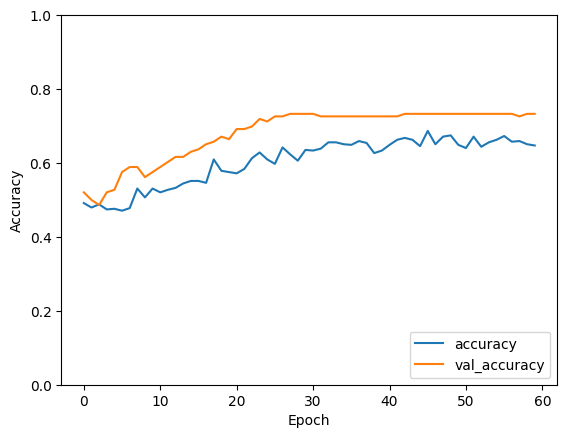

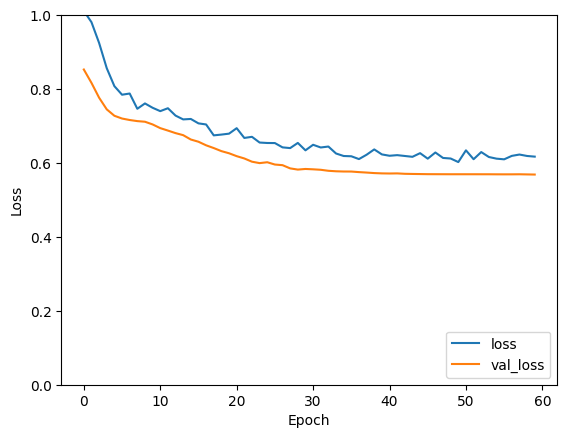

In [7]:

# ViT


def lrate(epoch):
    # Warmup
    wrmup = 18
    peak = 0.0004
    stay = 10
    lenght_decay = 60
    if epoch < wrmup:
        return peak * (epoch+1) / wrmup
    elif epoch < wrmup + stay:
        return peak
    else:
        return peak/2 * (1 + np.cos((epoch-wrmup) / (  lenght_decay - stay - wrmup) * np.pi))

train_model_vit(X_train_o, X_test_o, y_train, y_test, X_test_o, y_test,  lrate, 'vit-test-7', 60)

    
    



In [3]:
# Load model directly
from transformers import AutoImageProcessor, AutoModelForImageClassification
import torch
import os
UP_DIR = os.path.dirname(os.getcwd())
UP_DIR = os.path.dirname(UP_DIR)
DATASET_DIR = os.path.join(UP_DIR, 'data', 'dataset')





# Load processor
processor = AutoImageProcessor.from_pretrained("microsoft/swin-base-patch4-window7-224-in22k")
# Load model with classification head for 2 classes
model = AutoModelForImageClassification.from_pretrained("microsoft/swin-base-patch4-window7-224-in22k", num_labels=2, ignore_mismatched_sizes=True)

# train using trainer from hugging face
from transformers import TrainingArguments, Trainer
# mkdir results
if not os.path.exists('results'):
    os.makedirs('results')
# mkdir logs
if not os.path.exists('logs'):
    os.makedirs('logs')
    
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
)



# Load data

from datasets import load_dataset
import cv2
dataset_train = load_dataset( 'imagefolder', data_dir=DATASET_DIR, split='train')
dataset_test = load_dataset( 'imagefolder', data_dir=DATASET_DIR, split='test')
dataset_val = load_dataset( 'imagefolder', data_dir=DATASET_DIR, split='validation')

# print head 
print(dataset_train[0])




Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.
Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-base-patch4-window7-224-in22k and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([21841]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([21841, 1024]) in the checkpoint and torch.Size([2, 1024]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=224x224 at 0x7F2FB0637A60>, 'label': 0}


In [4]:
import numpy as np
# Preprocess data
def preprocess_function(examples):
    # example image is PIL.PngImagePlugin.PngImageFile image mode=RGB size=224x224
    images = []
    for image in examples["image"]:
        # Convert to numpy array
        image = np.array(image)
        # check shape
        print(image.shape)

        images.append(image)
    # Convert to tensor
    images = torch.tensor(images)
    # Normalize
    images = images / 255.0
    return {"pixel_values": images, "label": examples["label"]}

# Apply preprocess function
dataset_train = dataset_train.map(preprocess_function, batched=True)
dataset_test = dataset_test.map(preprocess_function, batched=True)
dataset_val = dataset_val.map(preprocess_function, batched=True)


Map:   0%|          | 0/525 [00:06<?, ? examples/s]


NameError: name 'np' is not defined

In [ ]:

# Verify tensor
print(dataset_train['pixel_values'][0].shape)
# Define trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_train,
    eval_dataset=dataset_test,

)

# Train model
trainer.train()

# Save model
trainer.save_model("results")

# Evaluate model
trainer.evaluate( eval_dataset=dataset_val)





In [20]:
print(dataset_train['pixel_values'][0].shape)

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f9016a0c940>>
Traceback (most recent call last):
  File "/home/vdgaete/anaconda3/envs/py310/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


AttributeError: 'list' object has no attribute 'shape'